In [14]:
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import pearsonr, spearmanr
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sentence_transformers import SentenceTransformer
from datasets import load_dataset
from topsis102203633Danishsharma_core.topsis import Topsis



In [15]:
# Load a suitable dataset (STS Benchmark)
dataset = load_dataset("stsb_multi_mt", "en", split="train")
sentences1 = dataset["sentence1"]
sentences2 = dataset["sentence2"]
gold_scores = np.array(dataset["similarity_score"]) / 5.0  # Normalize to 0-1 range

# Define pretrained models to test
models = [
    "all-MiniLM-L6-v2", 
    "paraphrase-MiniLM-L12-v2", 
    "sentence-t5-base",
    "distilbert-base-nli-stsb-mean-tokens",
    "bert-base-nli-mean-tokens"
]

results = []



In [16]:
# Evaluate each model
for model_name in models:
    try:
        print(f"\nEvaluating {model_name}...")
        model = SentenceTransformer(model_name)
        start_time = time.time()
        embeddings1 = model.encode(sentences1[:1000], show_progress_bar=True)
        embeddings2 = model.encode(sentences2[:1000], show_progress_bar=True)
        cos_sims = np.sum(embeddings1 * embeddings2, axis=1) / (
            np.linalg.norm(embeddings1, axis=1) * np.linalg.norm(embeddings2, axis=1)
        )
        inference_time = time.time() - start_time
        pearson = pearsonr(gold_scores[:1000], cos_sims)[0]
        spearman = spearmanr(gold_scores[:1000], cos_sims)[0]
        mae = mean_absolute_error(gold_scores[:1000], cos_sims)
        mse = mean_squared_error(gold_scores[:1000], cos_sims)
        short_name = model_name.split("/")[-1]
        results.append({
            'Model': short_name,
            'Pearson': pearson,
            'Spearman': spearman,
            'MAE': mae,
            'MSE': mse,
            'InferenceTime': inference_time
        })
    except Exception as e:
        print(f"Error evaluating {model_name}: {str(e)}\n")
        continue




Evaluating all-MiniLM-L6-v2...


Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]


Evaluating paraphrase-MiniLM-L12-v2...


Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]


Evaluating sentence-t5-base...


Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]


Evaluating distilbert-base-nli-stsb-mean-tokens...


Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]


Evaluating bert-base-nli-mean-tokens...


Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

In [17]:
# Convert results to DataFrame
if not results:
    raise ValueError("No models were successfully evaluated. Check errors above.")
results_df = pd.DataFrame(results)

# Define weights and impacts for TOPSIS
weights = [0.3, 0.3, 0.1, 0.2, 0.1]  # Adjust based on importance
impacts = ['+', '+', '-', '-', '-']  # Higher Pearson & Spearman are better, lower MAE/MSE are better

# Apply TOPSIS
topsis = Topsis(results_df, weights, impacts, distance_metric='euclidean',reverse_rank=True)
topsis_result = topsis.calculate()

# Merge TOPSIS results with original DataFrame
results_df['TOPSIS Score'] = topsis_result['Topsis Score']
results_df['Rank'] = topsis_result['Rank']
results_df = results_df.sort_values(by='Rank')



/usr/local/lib/python3.10/dist-packages/topsis102203633Danishsharma_core/topsis.py:72: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ideal_solution[i], negative_ideal_solution[i] = negative_ideal_solution[i], ideal_solution[i]
/usr/local/lib/python3.10/dist-packages/topsis102203633Danishsharma_core/topsis.py:72: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ideal_solution[i], negative_ideal_solution[i] = negative_ideal_solution[i], ideal_solution[i]


In [18]:


# Save results to CSV
results_df.to_csv("model_comparison_results.csv", index=False)
print("Results saved to model_comparison_results.csv")


Results saved to model_comparison_results.csv


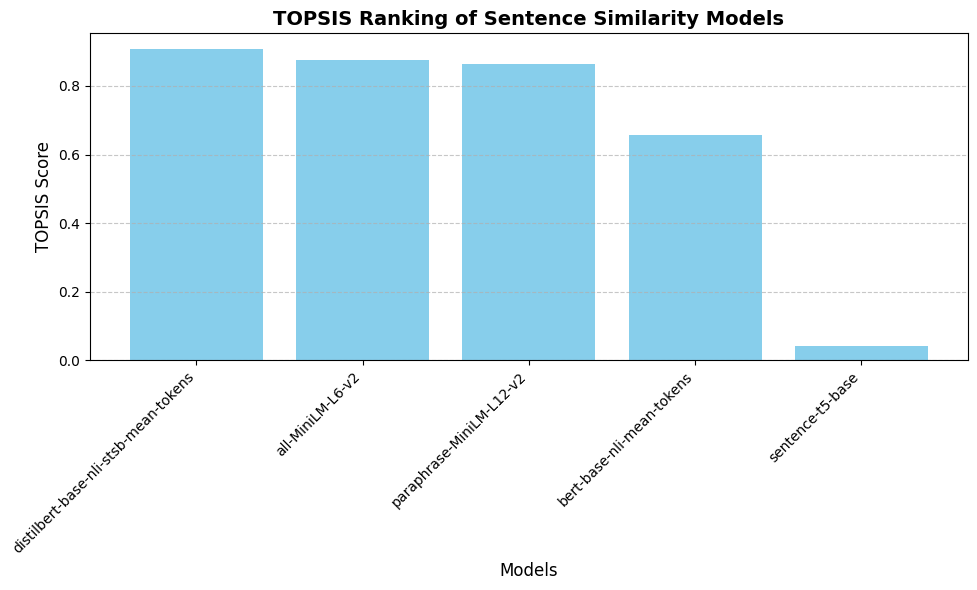

Graph saved as topsis_ranking_plot.png


In [19]:

# Plot and save the graph
plt.figure(figsize=(10, 6))
plt.bar(results_df['Model'], results_df['TOPSIS Score'], color='skyblue')
plt.xlabel("Models", fontsize=12)
plt.ylabel("TOPSIS Score", fontsize=12)
plt.title("TOPSIS Ranking of Sentence Similarity Models", fontsize=14, fontweight='bold')
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.yticks(fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig("topsis_ranking_plot.png", dpi=300)
plt.show()
print("Graph saved as topsis_ranking_plot.png")
